# Visão Computacional - Lista de Exercícios 3
Alunos:
- Luana Júlia Nunes Ferreira
- Lucas Mendes Massa

# Questão 1

In [1]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

In [2]:
def describe(image):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    (kps,features) = sift.detectAndCompute(image,None)
    kps = np.float32([kp.pt for kp in kps])
    return (kps,features)

In [3]:
def match(kA,kB,fA,fB,ratio,thresh):
    matcher = cv2.DescriptorMatcher_create('BruteForce')
    raw = matcher.knnMatch(fA,fB,2)
    matches = []
    for m in raw:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    
    if len(matches) > 4:
        ptsA = np.float32([kA[i] for (_, i) in matches])
        ptsB = np.float32([kB[i] for (i, _) in matches])
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, thresh)
        return (matches, H, status)

    return None

In [31]:
def twoImagesPanorama(images,ratio=0.75,thresh=4):
    (imA,imB) = images
    (kA,fA) = describe(imA)
    (kB,fB) = describe(imB)
    M = match(kA, kB, fA, fB, ratio, thresh)
    if M is None:
        return None
        
    (matches, H, status) = M
#     result = cv2.warpPerspective(imA, H,(imA.shape[1] + imB.shape[1], imA.shape[0]))
#     result[0:imB.shape[0], 0:imB.shape[1]] = imB

    h1,w1 = imB.shape[:2]
    h2,w2 = imA.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    
    result = cv2.warpPerspective(imA, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = imB
    return result

In [32]:
imageA = cv2.imread('./p1.png')
imageB = cv2.imread('./p2.png')
imageA = imutils.resize(imageA, width=400,height=220)
imageB = imutils.resize(imageB, width=400,height=220)
imageA = cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB)
imageB = cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB)

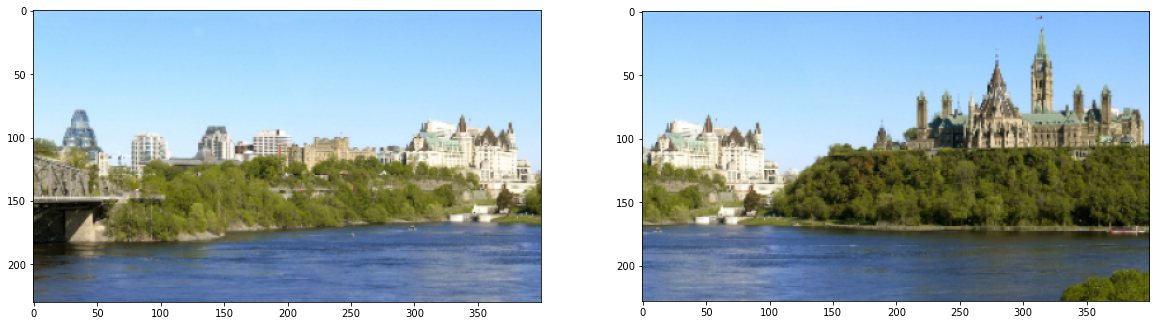

In [33]:
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(imageA)
axarr[1].imshow(imageB)

In [34]:
result = twoImagesPanorama((imageA,imageB))

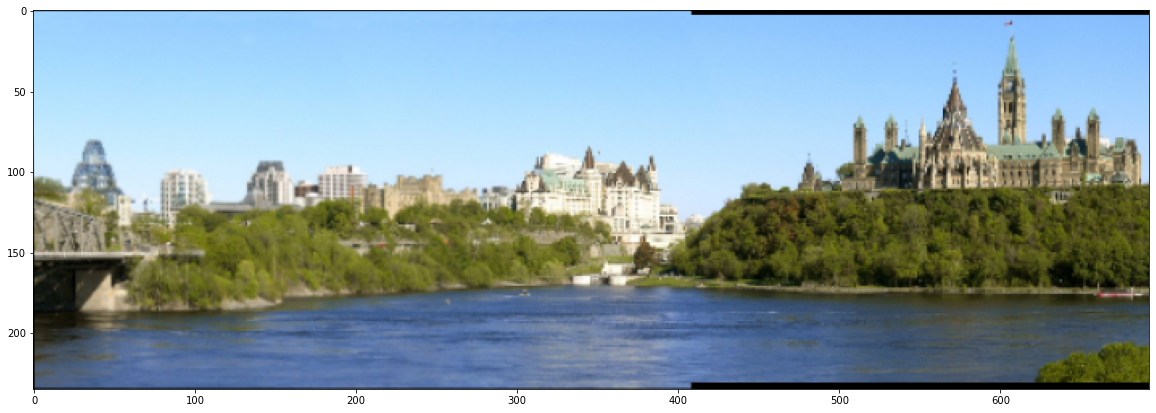

In [35]:
plt.figure(figsize=(20,20))
plt.imshow(result)